# Dataset Bug Detection

In this example, we will demonstrate how to detect bugs in a data set using the public Airlines data set.

In [ ]:
# Since we use the category_encoders library to perform binary encoding on some of the features in this demo, 
# we'll need to install it.
!pip install category_encoders

In [1]:
import pandas
pandas.options.display.max_rows=5 # restrict to 5 rows on display

df = pandas.read_csv("https://raw.githubusercontent.com/Devvrat53/Flight-Delay-Prediction/master/Data/flight_data.csv")
df['date'] = pandas.to_datetime(df[['year', 'month', 'day']])
df['day_index'] = (df['date'] - df['date'].min()).dt.days
df['DayOfWeek'] = df['date'].dt.day_name()
df['Month'] = df['date'].dt.month_name()
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,date,day_index,DayOfWeek,Month
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,IAH,227.0,1400,5,15,1/1/2013 5:00,2013-01-01,0,Tuesday,January
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,IAH,227.0,1416,5,29,1/1/2013 5:00,2013-01-01,0,Tuesday,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,...,CLE,NaN,419,11,59,30-09-2013 11:00,2013-09-30,272,Monday,September
336775,2013,9,30,NaN,840,NaN,NaN,1020,NaN,MQ,...,RDU,NaN,431,8,40,30-09-2013 08:00,2013-09-30,272,Monday,September


## Prepare daily data

Let's assume that we run new data each day through our model. For simplicity we will just look at the last 10 days of data.

In [2]:
df_daily = df[df['month'] > 11]

In [3]:
df_daily = df_daily[df_daily['day'] > 20]

In [4]:
df_daily

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,date,day_index,DayOfWeek,Month
101780,2013,12,21,2.0,2359,3.0,445.0,445,0.0,B6,...,PSE,206.0,1617,23,59,21-12-2013 23:00,2013-12-21,354,Saturday,December
101781,2013,12,21,29.0,2040,229.0,138.0,2220,198.0,WN,...,MDW,117.0,725,20,40,21-12-2013 20:00,2013-12-21,354,Saturday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111294,2013,12,31,NaN,600,NaN,NaN,735,NaN,UA,...,ORD,NaN,719,6,0,31-12-2013 06:00,2013-12-31,364,Tuesday,December
111295,2013,12,31,NaN,830,NaN,NaN,1154,NaN,UA,...,LAX,NaN,2475,8,30,31-12-2013 08:00,2013-12-31,364,Tuesday,December


## Bug Detection

Now we want to find any bugs in any of our daily sets of data that we feed to our model.
Note that we are performing binary encoding on the categorical columns (carrier, origin, and dest) so that we can pass the data to the variational estimation function directly. We are doing this for performance reasons vs. the hybrid estimation, and to strike a balance between plain index encoding and one-hot encoding.

In [5]:
import category_encoders as ce
from mvtk.supervisor.utils import compute_divergence_crosstabs
from mvtk.supervisor.divergence import calc_tv_knn

columns = ['dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay', 'air_time', 'distance', 'hour', 'minute', 'carrier', 'origin', 'dest']

encoder = ce.BinaryEncoder(cols=['carrier', 'origin', 'dest'])
encoder.fit(df_daily[columns + ['day']])
df_daily_encoded = encoder.transform(df_daily[columns + ['day']].fillna(0))

f = lambda x, y: calc_tv_knn(x, y, k = 26)
result = compute_divergence_crosstabs(df_daily_encoded, datecol='day', divergence=f)

0it [00:00, ?it/s]

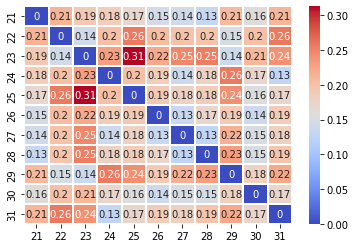

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(result, cmap='coolwarm', linewidths=0.30, annot=True)
plt.show()

As you can see from the heatmap above, although there are some divergences between the days, there is nothing that is too alarming.

Let's now update our data set to contain a "bug" in the "sched_dep_time" feature. For day 30, all of the values of that feature are null (which we are then translating to 0).

In [7]:
df_daily.loc[df_daily['day'] == 30, ['sched_dep_time']] = None

Below is the percentage of scheduled departure times that are empty per day in our updated daily data set

In [8]:
day = 21
for df_day in df_daily.groupby('day'):
    day_pct = df_day[1]['sched_dep_time'].value_counts(normalize=True, dropna=False) * 100
    pct = day_pct.loc[day_pct.index.isnull()].values
    if (len(pct) == 0):
        pct = 0
    else:
        pct = pct[0]
    print('Day ' + str(day) + ': ' + str(round(pct)) + '%')
    day += 1

Day 21: 0%
Day 22: 0%
Day 23: 0%
Day 24: 0%
Day 25: 0%
Day 26: 0%
Day 27: 0%
Day 28: 0%
Day 29: 0%
Day 30: 100%
Day 31: 0%


In [9]:
from mvtk.supervisor.divergence import calc_tv_knn

encoder = ce.BinaryEncoder(cols=['carrier', 'origin', 'dest'])
encoder.fit(df_daily[columns + ['day']])
df_daily_encoded = encoder.transform(df_daily[columns + ['day']].fillna(0))

f = lambda x, y: calc_tv_knn(x, y, k = 26)
result = compute_divergence_crosstabs(df_daily_encoded, datecol='day', divergence=f)

0it [00:00, ?it/s]

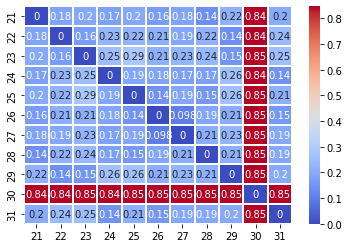

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(result, cmap='coolwarm', linewidths=0.30, annot=True)
plt.show()

As we can see above, our heatmap now clearly shows that we have a "bug" in our day 30 dataset.